In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
rng = np.random.default_rng()
def sample_from_ssrw(log_n, log_length):
    n, length = int(10**log_n), int(10**log_length)
    samples = list()
    if length > 1e8: # do one sample at a time
        for _ in range(n):
            length_remain = length
            where = 0
            while length_remain > 1e8:
                where += (rng.integers(2, size=(int(1e8))).sum()*2-int(1e8))
                length_remain -= 1e8
            where += (rng.integers(2, size=(int(length_remain))).sum()*2-int(length_remain))
            samples.append(where)
    else: # do multiple samples at a time
        n_remain = n
        n_each_step = int(10**(8 - log_length))
        while n_remain > n_each_step:
            samples.extend(rng.integers(2, size=(n_each_step, length)).sum(axis=1)* 2 - length)
            n_remain -= n_each_step
        samples.extend(rng.integers(2, size=(n_remain, length)).sum(axis=1)* 2 - length)
    return np.array(samples) / length**0.5

def piecewise_linearized_normal_cdf(x, dx):
    # linear between data points
    # decompose: x = q * dx + r
    # q = x // dx
    # r = x - q * dx
    # # linear interpolation of normal.cdf between q*dx and (q+1)*dx
    # return (1- r / dx) * stats.norm.cdf(q * dx) + (r / dx) * stats.norm.cdf((q + 1) * dx)

    # linear at data points
    # decompose: x = (q + 1/2) * dx + r
    q = (x - dx / 2) // dx
    r = x - (q + 1/2) * dx
    # linear interpolation of normal.cdf between q*dx and (q+1)*dx
    return (1- r / dx) * stats.norm.cdf((q+1/2) * dx) + (r / dx) * stats.norm.cdf((q + 1 + 1/2) * dx)
    

def adapted_ks_pvalue(log_n, log_length):
    samples = sample_from_ssrw(log_n, log_length)
    
    piecewise_cdf = lambda x: piecewise_linearized_normal_cdf(x, 2/10**(0.5*log_length)) # resolution formulae; see note

    # ks test
    return stats.kstest(samples, piecewise_cdf)[1]

    
    


    
        


In [ ]:

def test_pvalue(log_n, log_length):
    print("n = 10^", log_n, ", length = 10^", log_length)
    samples = sample_from_ssrw(log_n, log_length)

    resolution = 2/10**(0.5*log_length) # resolution formulae; see note
    piecewise_cdf = lambda x: piecewise_linearized_normal_cdf(x, resolution) 

    # add random noise to samples
    samples_noised = samples + rng.uniform(-0.5* resolution, 0.5*resolution, size=samples.shape)

    # ks test
    stat, p =  stats.kstest(samples_noised, piecewise_cdf)
    # print(f"stat = {stat}, p = {p}")
    return p, samples, samples_noised, piecewise_cdf
p, samples, samples_noised, piecewise_cdf = test_pvalue(log_n = 1,log_length = 0.8)

n = 10^ 7 , length = 10^ 2


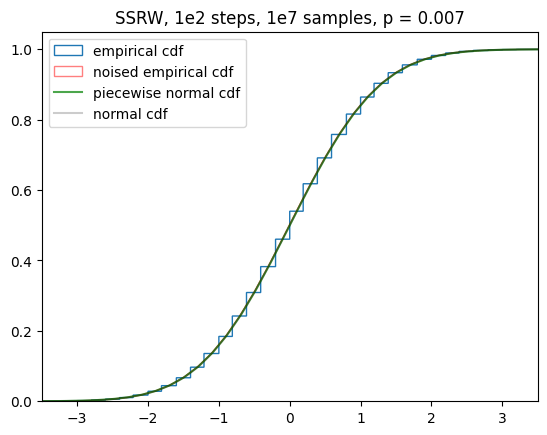

In [114]:
log_n = 7;log_length = 2
p, samples, samples_noised, piecewise_cdf = test_pvalue(log_n,log_length)
# plot samples cumulative hist
# high resolution figure
# plt.figure(figsize=(30, 30))
plt.hist(samples, bins=1000, density=True, cumulative=True, histtype='step', label='empirical cdf')
plt.hist(samples_noised, bins=1000, density=True, cumulative=True, 
histtype='step', color='red', alpha=0.5, label='noised empirical cdf')
x= np.linspace(-5, 5, 10000)
plt.plot(x, piecewise_cdf(x), color='green', alpha = 0.7, label='piecewise normal cdf')
plt.plot(x, stats.norm.cdf(x), color='black', alpha = 0.2, label='normal cdf')
plt.xlim(-3.5, 3.5)
plt.legend()
# title: __ steps, __ samples
plt.title(f'SSRW, 1e{log_length} steps, 1e{log_n} samples, p = {p:.3f}')
plt.show()

In [106]:
pvalue = lambda log_n, log_length: test_pvalue(log_n, log_length)[0]
x = np.linspace(1, 6, 11)
y = np.linspace(1, 6,11)
X, Y = np.meshgrid(x, y)
# Z = np.vectorize(pvalue)(X, Y)
# np.save('pvalue.npy', Z)
# print('saved')


In [ ]:
plt.pcolormesh(X, Y, Z)
plt.colorbar()
plt.xlabel('log10(n)')
plt.ylabel('log10(length)')
plt.title('p-value for normal test')

In [ ]:
from multiprocessing import Pool, cpu_count

# xx,yy = np.meshgrid(x,y)
# mesh = list(zip(xx.flatten(), yy.flatten()))

# # Make the Pool of workers
# pool = Pool(4)
# # Open the urls in their own threads
# # and return the results
# def pvalue(A):
#     return test_pvalue(A[0], A[1])[0]
# results = pool.map(pvalue, mesh)
# #close the pool and wait for the work to finish
# pool.close()
# pool.join()
cpu_count()

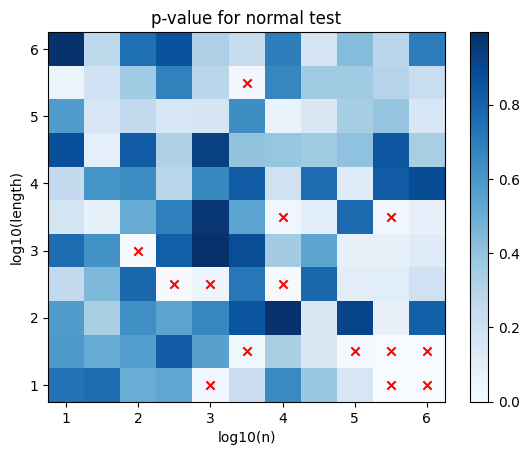

In [110]:
# Load results.npy
Z = np.load('../results.npy')
plt.pcolormesh(X, Y, Z)

plt.colorbar()
# blues colorscheme
plt.set_cmap('Blues')
plt.xlabel('log10(n)')
plt.ylabel('log10(length)')
plt.title('p-value for normal test')
# put a red x on the points with value smaller than 0.05
plt.scatter(X[Z<0.05], Y[Z<0.05], marker='x', color='red')
plt.show()

In [96]:
x = np.linspace(1, 6,11)
y = np.linspace(1, 6,11)
xx,yy = np.meshgrid(x,y)
mesh = list(zip(xx.flatten(), yy.flatten()))
np.array(mesh).reshape(11,11,2)

array([[[1. , 1. ],
        [1.5, 1. ],
        [2. , 1. ],
        [2.5, 1. ],
        [3. , 1. ],
        [3.5, 1. ],
        [4. , 1. ],
        [4.5, 1. ],
        [5. , 1. ],
        [5.5, 1. ],
        [6. , 1. ]],

       [[1. , 1.5],
        [1.5, 1.5],
        [2. , 1.5],
        [2.5, 1.5],
        [3. , 1.5],
        [3.5, 1.5],
        [4. , 1.5],
        [4.5, 1.5],
        [5. , 1.5],
        [5.5, 1.5],
        [6. , 1.5]],

       [[1. , 2. ],
        [1.5, 2. ],
        [2. , 2. ],
        [2.5, 2. ],
        [3. , 2. ],
        [3.5, 2. ],
        [4. , 2. ],
        [4.5, 2. ],
        [5. , 2. ],
        [5.5, 2. ],
        [6. , 2. ]],

       [[1. , 2.5],
        [1.5, 2.5],
        [2. , 2.5],
        [2.5, 2.5],
        [3. , 2.5],
        [3.5, 2.5],
        [4. , 2.5],
        [4.5, 2.5],
        [5. , 2.5],
        [5.5, 2.5],
        [6. , 2.5]],

       [[1. , 3. ],
        [1.5, 3. ],
        [2. , 3. ],
        [2.5, 3. ],
        [3. , 3. ],
        [3.5